<a href="https://colab.research.google.com/github/matiasmartineza/VITAPRO/blob/main/Modelacion__v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!python --version

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

# Variables de cálculo
tiempo_total = 86400  # Tiempo total de simulación en segundos (24 horas)
paso_de_tiempo = 1  # Paso de tiempo para la simulación en segundos

# Variables de modelo general
caudal_fijo_A1 = 0.02512 # m3/s
caudal_fijo_A2 = 0.0668533 # m3/s
caudal_fijo_B = 0.005888 # m3/s
entrada_fija = caudal_fijo_A2 + caudal_fijo_B  # Caudal de entrada fija al sistema (m³/s)
salida_fija = 0.0833333  # Caudal de salida fija del sistema (m³/s)

#Variables estanque ecualizador
volumen_minimo_drenaje = 35.1858  # Volumen mínimo del estanque para permitir la salida (m³)

# Variables de limpieza por succión
inicio_limpieza_succión = 0  # Hora de inicio de la limpieza por succión (8:00 AM)
duracion_limpieza_succión = 5  # Duración de la limpieza por succión en minutos
valor_base = entrada_fija  # Valor base del caudal de limpieza por succión (m³/s)
k1 = 0.8  # Fracción de caudal de la planta proveniente de aguas de mar

# Variables de flushing
porcentaje_vaciado = 65  # Porcentaje de vaciado de los estanques en el proceso de flushing
drenado_max = 40  # Volumen máximo de drenado en el proceso de flushing (m³)
caudal_max_colector_A1 = 300  # Caudal máximo de flushing permitido en el colector A1 (m³/h) (No considera aporte fijo)
caudal_max_colector_A2 = 500  # Caudal máximo de flushing permitido en el colector A2 (m³/h) (No considera aporte fijo)
#caudal_max_colector_B = 270  # Caudal máximo permitido en el colector B (m³/h)
caudal_max_colector_B = 200  # Caudal máximo permitido en el colector B (m³/h)
factor_seguridad_flushing = 1.1  # Factor de seguridad aplicado al proceso de flushing

Python 3.9.16


# Cálculo Caudal Limpieza línea de succión

In [50]:
def generar_intervalos_temporales(tiempo_total, paso_de_tiempo):
    # Calcula el número de intervalos de tiempo en función del tiempo total y el paso de tiempo
    num_intervalos = int(tiempo_total / paso_de_tiempo)
    
    # Crea un arreglo de ceros con la misma longitud que el número de intervalos de tiempo
    intervalos = np.zeros(num_intervalos)
    
    return intervalos

def generar_caudal_limpieza_succión(tiempo_total, paso_de_tiempo, inicio, duracion_minutos, valor_base, k1):
    # Calcula el número de intervalos de tiempo en función del tiempo total y el paso de tiempo
    num_intervalos = int(tiempo_total / paso_de_tiempo)
    
    # Crea un arreglo de ceros con la misma longitud que el número de intervalos de tiempo
    caudal_limpieza_succión = np.zeros(num_intervalos)
    
    # Convierte las horas de inicio y fin en índices de intervalo de tiempo
    inicio_intervalo = int(inicio * 3600 / paso_de_tiempo)
    fin_intervalo = int((inicio * 3600 + duracion_minutos * 60) / paso_de_tiempo)

    # Asigna el valor del caudal de limpieza por succión durante el período de limpieza
    for i in range(inicio_intervalo, fin_intervalo):
        caudal_limpieza_succión[i] = valor_base * k1
    
    return caudal_limpieza_succión

# Llama a la función generar_caudal_limpieza_succión para obtener el caudal de limpieza por succión en función del tiempo
caudal_limpieza_succión = generar_caudal_limpieza_succión(tiempo_total, paso_de_tiempo, inicio_limpieza_succión, duracion_limpieza_succión, valor_base, k1)


# Cálculo Caudal Flushing

## Definición caudales flushing por estanque

In [51]:
# Identificación de las salas
id_salas = [
    "Puelche_Sala1", "Puelche_Sala2", "Lenca_RAS1", "Lenca_RAS2", "Lenca_RAS3",
    "Metri_Sala1", "Quillaipe_Sala1", "Quillaipe_Sala2", "Reloncavi_ext_Sala1",
    "Reloncavi_Sala1", "Reloncavi_Sala2", "Piedra_Azul_Sala1", "Piedra_Azul_Sala2",
    "Chamiza_Sala1", "Chamiza_Sala2", "Chamiza_Sala3", "Chamiza_Sala4", "Chamiza_Sala5",
    "Coihuin_Sala1", "Coihuin_Sala2"
]

# Volumenes de los estanques en cada sala (m³)
volumenes_estanques = [
    0.35, 9.00, 0.60, 0.60, 3.00, 12.00, 1.00, 0.50, 3.00, 25.00, 15.00,
    1.00, 0.50, 0.72, 0.72, 0.72, 0.50, 0.50, 0.35, 0.35
]

# Cantidad de estanques por sala
cant_estanques_por_sala = [
    24, 12, 12, 24, 12, 9, 21, 24, 10, 2, 4, 18, 28, 12, 12, 9, 12, 12, 12, 12
]

# Altura máxima de los estanques en cada sala (m)
altura_max_estanques = [
    0.70, 0.94, 0.76, 0.76, 0.95, 1.06, 3.01, 0.53, 0.95, 1.99, 1.29, 0.75,
    0.53, 0.54, 0.54, 0.54, 0.53, 0.53, 0.79, 0.79
]

# Diámetro del orificio de descarga en cada sala (m)
diametro_orificio_descarga = [
    0.06, 0.06, 0.06, 0.06, 0.06, 0.16, 0.06, 0.06, 0.06, 0.16, 0.16, 0.06,
    0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06
]


In [52]:
# Función para calcular el vaciado de un estanque utilizando la ecuación de Torricelli
def torricelli(volumen_inicial, paso_de_tiempo, porcentaje_vaciado, diametro_salida, altura_inicial):
    g = 9.81  # Aceleración debida a la gravedad (m/s²)
    volumen_final = volumen_inicial * (1 - porcentaje_vaciado / 100)
    area_salida = np.pi * (diametro_salida / 2) ** 2

    volumen = volumen_inicial
    altura = altura_inicial
    volumenes = []
    caudales_salida = []
    tiempo = 0

    # Iterar hasta que el volumen sea menor al volumen final deseado
    while volumen > volumen_final:
        # Calcular la velocidad de salida usando la ecuación de Torricelli
        v = np.sqrt(2 * g * altura)
        # Calcular el caudal de salida
        caudal_salida = area_salida * v
        caudales_salida.append(caudal_salida)

        # Actualizar el volumen y la altura del estanque
        volumen -= caudal_salida * paso_de_tiempo
        volumenes.append(volumen)
        altura = volumen / volumen_inicial * altura_inicial

        tiempo += paso_de_tiempo

    return np.array(volumenes), np.array(caudales_salida), tiempo

# Función para calcular el volumen en movimiento
def volumen_en_movimiento(caudal, dt):
    n = len(caudal)
    volumen = [0.0] * n
    # Calcular el volumen acumulado en función del caudal
    for i in range(1, n):
        volumen[i] = volumen[i-1] + (caudal[i] + caudal[i-1]) * dt / 2.0
    return volumen

# Función para calcular el vaciado de un conjunto de estanques por sala
def flushing_por_sala(indice_sala, num_estanques_vaciar, desfase_temporal, paso_de_tiempo, porcentaje_vaciado, volumenes_estanques, altura_max_estanques, diametro_orificio_descarga):
    volumen_inicial = volumenes_estanques[indice_sala]
    altura_inicial = altura_max_estanques[indice_sala]
    diametro_salida = diametro_orificio_descarga[indice_sala]

    caudales_totales = []

    # Iterar sobre el número de estanques a vaciar
    for i in range(num_estanques_vaciar):
        desfase_actual = i * desfase_temporal
        volumenes, caudales_salida, _ = torricelli(volumen_inicial, paso_de_tiempo, porcentaje_vaciado, diametro_salida, altura_inicial)

        # Sumar los caudales de salida de todos los estanques
        if i == 0:
            caudales_totales = np.pad(caudales_salida, (desfase_actual, 0))
        else:
            #volumenes_temp = np.pad(volumenes, (desfase_actual, 0))
            caudales_temp = np.pad(caudales_salida, (desfase_actual, 0))

            max_len = max(len(caudales_totales), len(caudales_temp))
            #volumenes_evacuados = np.pad(volumenes_evacuados, (0, max_len - len(volumenes_evacuados))) + np.pad(volumenes_temp, (0, max_len - len(volumenes_temp)))
            caudales_totales = np.pad(caudales_totales, (0, max_len - len(caudales_totales))) + np.pad(caudales_temp, (0, max_len - len(caudales_temp)))

    volumenes_evacuados = volumen_en_movimiento(caudales_totales, paso_de_tiempo)

    return volumenes_evacuados, caudales_totales


### Determinación de número máximo de estanques en flushing simultaneo

In [53]:
def calcular_max_estanques_vaciar(id_salas, cant_estanques_por_sala, paso_de_tiempo, porcentaje_vaciado, drenado_max, caudal_max_colector_A1, caudal_max_colector_A2, caudal_max_colector_B, factor_seguridad_flushing):
    max_estanques_vaciar = []

    # Salas pertenecientes a cada colector
    salas_colector_A1 = id_salas[0:5]
    salas_colector_A2 = id_salas[5:13]
    salas_colector_B = id_salas[13:]

    for indice_sala, estanques_totales in enumerate(cant_estanques_por_sala):
        num_estanques_vaciar = 0
        volumen_drenado_total = 0
        caudal_maximo = 0

        # Asignar el caudal máximo correspondiente al colector
        if id_salas[indice_sala] in salas_colector_A1:
            caudal_max_actual = caudal_max_colector_A1
        elif id_salas[indice_sala] in salas_colector_A2:
            caudal_max_actual = caudal_max_colector_A2
        else:
            caudal_max_actual = caudal_max_colector_B

        for i in range(1, int(estanques_totales) + 1):
            desfase_temporal = 0
            volumenes_evacuados, caudales_totales = flushing_por_sala(indice_sala, i, desfase_temporal, paso_de_tiempo, porcentaje_vaciado, volumenes_estanques, altura_max_estanques, diametro_orificio_descarga)
            volumen_drenado = volumenes_evacuados[-1]
            caudal_maximo_actual = caudales_totales[0] * 3600

            if volumen_drenado <= drenado_max / factor_seguridad_flushing and caudal_maximo_actual <= caudal_max_actual / factor_seguridad_flushing:
                num_estanques_vaciar = i
            else:
                break

        max_estanques_vaciar.append(num_estanques_vaciar)

    for i, k in enumerate(max_estanques_vaciar):
        if k < 1:
            max_estanques_vaciar[i] = 1

    return max_estanques_vaciar


max_estanques_vaciar = calcular_max_estanques_vaciar(id_salas, cant_estanques_por_sala, paso_de_tiempo, porcentaje_vaciado, drenado_max, caudal_max_colector_A1, caudal_max_colector_A2, caudal_max_colector_B, factor_seguridad_flushing)

# Calcular el número de vaciados necesarios para vaciar todos los estanques en cada sala
num_vaciados = [math.ceil(cant_total / max_vaciar) for cant_total, max_vaciar in zip(cant_estanques_por_sala, max_estanques_vaciar)]

In [54]:
# Función para graficar el volumen evacuado y el caudal total en función del tiempo
def graficar_salidas_tiempo(volumenes_evacuados, caudales_totales, paso_de_tiempo):
    tiempo_total = len(volumenes_evacuados) * paso_de_tiempo
    eje_tiempo = np.arange(0, tiempo_total, paso_de_tiempo)

    # Crear una figura y un conjunto de ejes
    fig, ax1 = plt.subplots()

    # Configurar las etiquetas y los colores del eje y para el volumen evacuado
    ax1.set_xlabel('Tiempo (s)')
    ax1.set_ylabel('Volumen evacuado (m³)', color='tab:blue')
    ax1.plot(eje_tiempo, volumenes_evacuados, color='tab:blue', label='Volumen evacuado')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Crear un segundo eje y para el caudal total, compartiendo el mismo eje x
    ax2 = ax1.twinx()
    
    # Configurar las etiquetas y los colores del eje y para el caudal total
    ax2.set_ylabel('Caudal total (m³/h)', color='tab:red')
    ax2.plot(eje_tiempo, caudales_totales * 3600, color='tab:red', label='Caudal total')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Ajustar el diseño de la gráfica y agregar un título
    fig.tight_layout()
    plt.title('Volumen evacuado y caudal total en función del tiempo')
    plt.show()

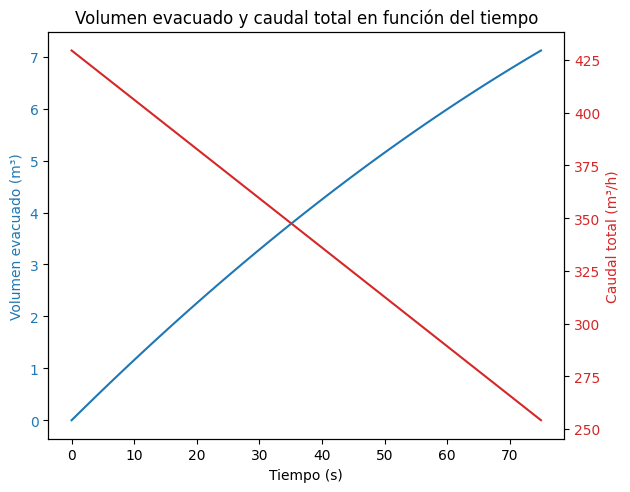

In [55]:
# Ejemplo de uso:
indice_sala = 11
num_estanques_vaciar = int(max_estanques_vaciar[indice_sala])
desfase_temporal = 0

volumenes_evacuados, caudales_totales = flushing_por_sala(indice_sala, num_estanques_vaciar, desfase_temporal, paso_de_tiempo, porcentaje_vaciado, volumenes_estanques, altura_max_estanques, diametro_orificio_descarga)
graficar_salidas_tiempo(volumenes_evacuados, caudales_totales, paso_de_tiempo)

### Cálculo de tiempos de descarga

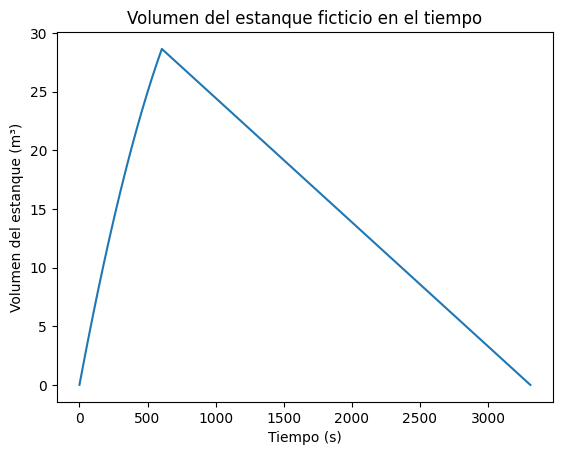

Tiempo total para drenar el caudal de flushing: 55.18333333333333 minutos


In [56]:
def estanque_ficticio(id_sala, num_estanques_vaciar, entrada_fija, salida_fija, paso_de_tiempo, porcentaje_vaciado):
    desfase_temporal = 0
    volumenes_evacuados, caudales_totales = flushing_por_sala(id_sala, num_estanques_vaciar, desfase_temporal, paso_de_tiempo, porcentaje_vaciado, volumenes_estanques, altura_max_estanques, diametro_orificio_descarga)
    volumen_estanque = [0]

    i = 1
    while True:
        volumen_anterior = volumen_estanque[-1]
        caudal_flushing = caudales_totales[i] if i < len(caudales_totales) else 0
        volumen_actual = volumen_anterior + (entrada_fija - salida_fija + caudal_flushing) * paso_de_tiempo
        volumen_estanque.append(volumen_actual)

        if volumen_actual <= 0:
            tiempo_total = i * paso_de_tiempo
            break

        i += 1

    return volumen_estanque[:i+1], tiempo_total

def tiempos_vaciado_salas(id_salas, max_estanques_vaciar, entrada_fija, salida_fija, paso_de_tiempo, porcentaje_vaciado):
    tiempos_vaciado = []

    for indice_sala, id_sala in enumerate(id_salas):
        num_estanques_vaciar = int(max_estanques_vaciar[indice_sala])
        _, tiempo_vaciado = estanque_ficticio(indice_sala, num_estanques_vaciar, entrada_fija, salida_fija, paso_de_tiempo, porcentaje_vaciado)
        tiempos_vaciado.append(tiempo_vaciado)

    return tiempos_vaciado

def graficar_estanque_ficticio(id_sala, num_estanques_vaciar, entrada_fija, salida_fija, paso_de_tiempo, porcentaje_vaciado):
    volumen_estanque, tiempo_drenaje = estanque_ficticio(id_sala, num_estanques_vaciar, entrada_fija, salida_fija, paso_de_tiempo, porcentaje_vaciado)
    _, caudales_totales = flushing_por_sala(id_sala, num_estanques_vaciar, 0, paso_de_tiempo, porcentaje_vaciado, volumenes_estanques, altura_max_estanques, diametro_orificio_descarga)
    
    tiempo = np.arange(len(volumen_estanque)) * paso_de_tiempo
    
    # Gráfica del volumen del estanque
    plt.figure()
    plt.plot(tiempo, volumen_estanque)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Volumen del estanque (m³)')
    plt.title('Volumen del estanque ficticio en el tiempo')
    plt.show()

# Ejemplo de uso:
id_sala_seleccionada = 1  # Elige el ID de la sala que deseas evaluar
num_estanques_vaciar = int(max_estanques_vaciar[id_sala_seleccionada])

volumen_estanque_ficticio, tiempo_drenaje = estanque_ficticio(id_sala_seleccionada, num_estanques_vaciar, entrada_fija, salida_fija, paso_de_tiempo, porcentaje_vaciado)
graficar_estanque_ficticio(id_sala_seleccionada, num_estanques_vaciar, entrada_fija, salida_fija, paso_de_tiempo, porcentaje_vaciado)
print(f"Tiempo total para drenar el caudal de flushing: {tiempo_drenaje / 60} minutos")

In [57]:
from tabulate import tabulate

def obtener_datos_flushing():
    datos = []

    # Calcular los tiempos de vaciado
    intermitencia_flushing = tiempos_vaciado_salas(id_salas, max_estanques_vaciar, entrada_fija, salida_fija, paso_de_tiempo, porcentaje_vaciado)

    for indice_sala, id_sala in enumerate(id_salas):
        num_estanques_vaciar = int(max_estanques_vaciar[indice_sala])
        desfase_temporal = 0
        volumenes_evacuados, caudales_totales = flushing_por_sala(indice_sala, num_estanques_vaciar, desfase_temporal, paso_de_tiempo, porcentaje_vaciado, volumenes_estanques, altura_max_estanques, diametro_orificio_descarga)
        caudal_maximo = np.max(caudales_totales) * 3600
        volumen_maximo = np.max(volumenes_evacuados)
        tiempo_intermitencia_minutos = intermitencia_flushing[indice_sala] / 60

        datos.append([id_sala, num_estanques_vaciar, caudal_maximo, volumen_maximo, tiempo_intermitencia_minutos, tiempo_intermitencia_minutos * 1.5])

    # Crear un DataFrame y ajustar los nombres de las columnas
    columnas = [
        'Nombre del\nedificio',
        'Estanques\nvaciados\nsimultáneamente',
        'Caudal\nmáximo\n(m³/h)',
        'Volumen\nvaciado\n(m³)',
        'Tiempo de\nintermitencia\n(min)',
        'Tiempo de\nespera recomendado\n(min)'
    ]
    tabla = pd.DataFrame(datos, columns=columnas)

    # Imprimir la tabla en formato profesional
    print(tabulate(tabla, headers=columnas, tablefmt='pipe', showindex=False, floatfmt=".1f"))

obtener_datos_flushing()

| Nombre del          |         Estanques |   Caudal |   Volumen |       Tiempo de |            Tiempo de |
| edificio            |          vaciados |   máximo |   vaciado |   intermitencia |   espera recomendado |
|                     |   simultáneamente |   (m³/h) |      (m³) |           (min) |                (min) |
|:--------------------|------------------:|---------:|----------:|----------------:|---------------------:|
| Puelche_Sala1       |                 7 |    264.1 |       1.6 |             2.5 |                  3.7 |
| Puelche_Sala2       |                 6 |    262.3 |      35.1 |            55.2 |                 82.8 |
| Lenca_RAS1          |                 6 |    235.8 |       2.3 |             3.6 |                  5.4 |
| Lenca_RAS2          |                 6 |    235.8 |       2.3 |             3.6 |                  5.4 |
| Lenca_RAS3          |                 6 |    263.7 |      11.7 |            18.3 |                 27.5 |
| Metri_Sala1         |     

## Definición caudal flushing

In [58]:
def generar_caudal_flushing_final(tiempo_total, paso_de_tiempo, max_estanques_vaciar, intermitencia_flushing, holgura_temporal):
    num_intervalos = int(tiempo_total / paso_de_tiempo)
    caudal_flushing_final = np.zeros(num_intervalos)

    inicio_flushing = 1 * 3600  # Hora de inicio del flushing (9:00 AM)
    tiempo_actual = inicio_flushing

    for i, (max_estanques, tiempo_vaciado) in enumerate(zip(max_estanques_vaciar, intermitencia_flushing)):
        _, caudales_totales = flushing_por_sala(i, int(max_estanques), 0, paso_de_tiempo, 65, volumenes_estanques, altura_max_estanques, diametro_orificio_descarga)

        inicio_intervalo = tiempo_actual // paso_de_tiempo
        fin_intervalo = inicio_intervalo + len(caudales_totales)

        if fin_intervalo > num_intervalos:
            fin_intervalo = num_intervalos
            caudales_totales = caudales_totales[:fin_intervalo - inicio_intervalo]

        caudal_flushing_final[inicio_intervalo:fin_intervalo] += caudales_totales

        # Actualizar el tiempo actual sumando el tiempo de vaciado de la sala actual y la holgura temporal
        tiempo_actual += tiempo_vaciado + holgura_temporal

    return caudal_flushing_final

# Ejemplo de uso
intermitencia_flushing = tiempos_vaciado_salas(id_salas, max_estanques_vaciar, entrada_fija, salida_fija, paso_de_tiempo, porcentaje_vaciado)
holgura_temporal = 60  # 1 minutos en segundos
caudal_flushing = generar_caudal_flushing_final(tiempo_total, paso_de_tiempo, max_estanques_vaciar, intermitencia_flushing, holgura_temporal)

In [59]:
def generar_caudal_flushing_final(tiempo_total, paso_de_tiempo, max_estanques_vaciar, intermitencia_flushing, holgura_temporal, num_vaciados):
    num_intervalos = int(tiempo_total / paso_de_tiempo)
    caudal_flushing_final = np.zeros(num_intervalos)

    inicio_flushing = 1 * 3600  # Hora de inicio del flushing (9:00 AM)
    intervalo_actual = inicio_flushing // paso_de_tiempo

    for i, (max_estanques, tiempo_vaciado, num_vaciados_sala) in enumerate(zip(max_estanques_vaciar, intermitencia_flushing, num_vaciados)):
        for j in range(num_vaciados_sala):
            _, caudales_totales = flushing_por_sala(i, int(max_estanques), 0, paso_de_tiempo, 65, volumenes_estanques, altura_max_estanques, diametro_orificio_descarga)

            fin_intervalo = intervalo_actual + len(caudales_totales)

            if fin_intervalo > num_intervalos:
                fin_intervalo = num_intervalos
                caudales_totales = caudales_totales[:fin_intervalo - intervalo_actual]

            caudal_flushing_final[intervalo_actual:fin_intervalo] += caudales_totales

            intervalo_actual += int((tiempo_vaciado + holgura_temporal) // paso_de_tiempo)

    return caudal_flushing_final

caudal_flushing = generar_caudal_flushing_final(tiempo_total, paso_de_tiempo, max_estanques_vaciar, intermitencia_flushing, holgura_temporal, num_vaciados)


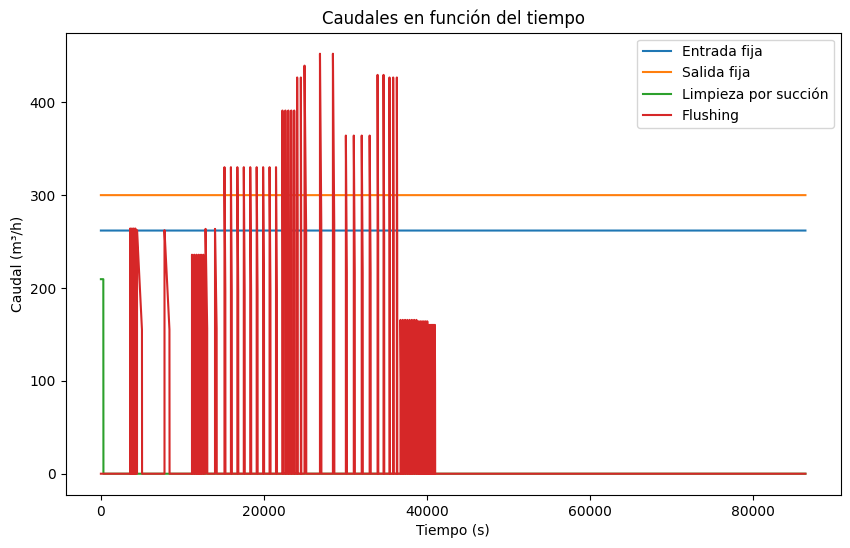

In [60]:
def graficar_caudales(tiempo_total, paso_de_tiempo, entrada_fija, salida_fija, caudal_limpieza_succión, caudal_flushing):
    num_intervalos = int(tiempo_total / paso_de_tiempo)
    eje_tiempo = np.arange(0, tiempo_total, paso_de_tiempo)
    
    plt.figure(figsize=(10, 6))
    plt.plot(eje_tiempo, np.full(num_intervalos, entrada_fija) * 3600, label='Entrada fija')
    plt.plot(eje_tiempo, np.full(num_intervalos, salida_fija) * 3600, label='Salida fija')
    plt.plot(eje_tiempo, caudal_limpieza_succión * 3600, label='Limpieza por succión')
    plt.plot(eje_tiempo, caudal_flushing * 3600, label='Flushing')
    
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Caudal (m³/h)')
    plt.title('Caudales en función del tiempo')
    plt.legend()
    plt.show()

graficar_caudales(tiempo_total, paso_de_tiempo, entrada_fija, salida_fija, caudal_limpieza_succión, caudal_flushing)

# Cálculo Estanque

In [61]:
def modelar_volumen_estanque(tiempo_total, paso_de_tiempo, entrada_fija, salida_fija, caudal_flushing, caudal_limpieza_succión, volumen_minimo_drenaje):
    intervalos = generar_intervalos_temporales(tiempo_total, paso_de_tiempo)
    volumen_estanque = np.copy(intervalos)
    volumen_estanque[0] = volumen_minimo_drenaje

    for i in range(1, len(volumen_estanque)):
        volumen_estanque[i] = volumen_estanque[i-1] + entrada_fija * paso_de_tiempo + caudal_flushing[i] * paso_de_tiempo + caudal_limpieza_succión[i] * paso_de_tiempo
        if volumen_estanque[i] >= volumen_minimo_drenaje:
            volumen_estanque[i] -= salida_fija * paso_de_tiempo

    return volumen_estanque

volumen_estanque = modelar_volumen_estanque(tiempo_total, paso_de_tiempo, entrada_fija, salida_fija, caudal_flushing, caudal_limpieza_succión, volumen_minimo_drenaje)

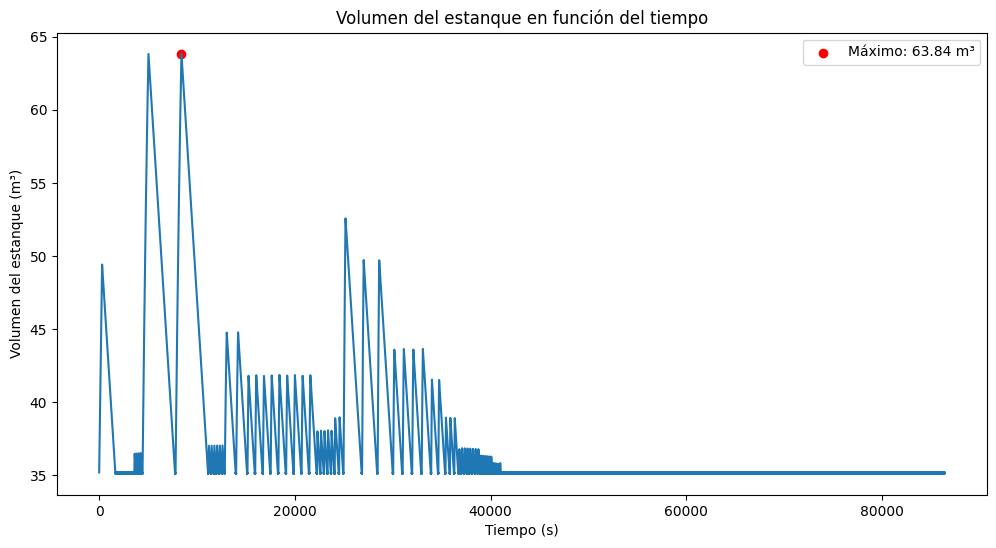

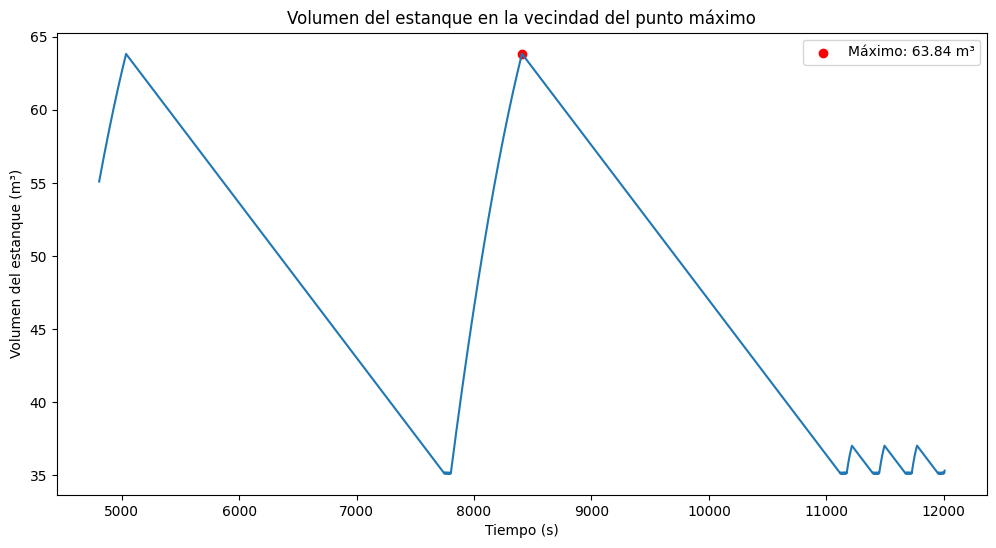

In [62]:
def graficar_volumen_estanque(volumen_estanque, paso_de_tiempo):
    num_intervalos = len(volumen_estanque)
    tiempo = np.arange(0, num_intervalos * paso_de_tiempo, paso_de_tiempo)

    # Graficar el volumen del estanque en función del tiempo
    plt.figure(figsize=(12, 6))
    plt.plot(tiempo, volumen_estanque)
    max_volumen = np.max(volumen_estanque)
    max_index = np.argmax(volumen_estanque)
    plt.scatter(tiempo[max_index], max_volumen, color='red', label=f'Máximo: {max_volumen:.2f} m³')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Volumen del estanque (m³)')
    plt.legend()
    plt.title('Volumen del estanque en función del tiempo')
    plt.show()

    # Graficar el volumen en la vecindad del punto máximo
    plt.figure(figsize=(12, 6))
    inicio_vecindad = max(0, max_index - int(3600 / paso_de_tiempo))
    fin_vecindad = min(num_intervalos, max_index + int(3600 / paso_de_tiempo))
    tiempo_vecindad = tiempo[inicio_vecindad:fin_vecindad]
    volumen_vecindad = volumen_estanque[inicio_vecindad:fin_vecindad]

    plt.plot(tiempo_vecindad, volumen_vecindad)
    plt.scatter(tiempo[max_index], max_volumen, color='red', label=f'Máximo: {max_volumen:.2f} m³')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Volumen del estanque (m³)')
    plt.legend()
    plt.title('Volumen del estanque en la vecindad del punto máximo')
    plt.show()

graficar_volumen_estanque(volumen_estanque, paso_de_tiempo)

# Gráfico de Caudales

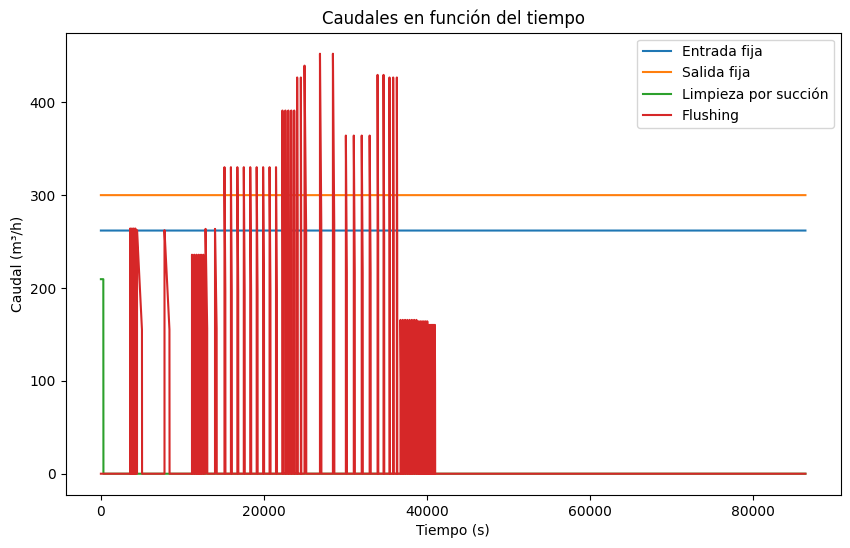

In [63]:
def graficar_caudales(tiempo_total, paso_de_tiempo, entrada_fija, salida_fija, caudal_limpieza_succión, caudal_flushing):
    num_intervalos = int(tiempo_total / paso_de_tiempo)
    eje_tiempo = np.arange(0, tiempo_total, paso_de_tiempo)
    
    plt.figure(figsize=(10, 6))
    plt.plot(eje_tiempo, np.full(num_intervalos, entrada_fija) * 3600, label='Entrada fija')
    plt.plot(eje_tiempo, np.full(num_intervalos, salida_fija) * 3600, label='Salida fija')
    plt.plot(eje_tiempo, caudal_limpieza_succión * 3600, label='Limpieza por succión')
    plt.plot(eje_tiempo, caudal_flushing * 3600, label='Flushing')
    
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Caudal (m³/h)')
    plt.title('Caudales en función del tiempo')
    plt.legend()
    plt.show()

graficar_caudales(tiempo_total, paso_de_tiempo, entrada_fija, salida_fija, caudal_limpieza_succión, caudal_flushing)

# Cálculo de colectores

In [64]:
# Variables para los colectores:

# Coeficiente de Manning: representa la rugosidad del material de la tubería
coeficiente_manning = 0.01

# Porcentaje de llenado: fracción de la tubería que está llena de agua (rango de 0 a 1)
porcentaje_llenado = 0.7

# Pendientes del colector A1: lista que contiene las pendientes de cada tramo del colector A1
pendientes_colector_A1 = np.ones(5) * 0.0055

# Pendientes del colector A2: lista que contiene las pendientes de cada tramo del colector A2
pendientes_colector_A2 = np.ones(10) * 0.0055

# Pendientes del colector B: lista que contiene las pendientes de cada tramo del colector B
pendientes_colector_B = np.ones(1) * 0.015

# Diámetro de la tubería A1: diámetro interno de la tubería del colector A1 en metros
diametro_tuberia_A1 = 0.308

# Diámetro de la tubería A2: diámetro interno de la tubería del colector A2 en metros
diametro_tuberia_A2 = 0.381

# Diámetro de la tubería B: diámetro interno de la tubería del colector B en metros
diametro_tuberia_B = 0.2


In [65]:
def obtener_caudal_maximo_real():
    # División de las salas según el colector al que pertenecen
    salas_colector_A1 = id_salas[0:5]
    salas_colector_A2 = id_salas[5:13]
    salas_colector_B = id_salas[13:]

    # Variables temporales para almacenar el caudal máximo encontrado en cada colector
    temp_A1 = 0.0
    temp_A2 = 0.0
    temp_B = 0.0

    # Iteración a través de cada sala
    for indice_sala, id_sala in enumerate(id_salas):
        # Número de estanques a vaciar en la sala actual
        num_estanques_vaciar = int(max_estanques_vaciar[indice_sala])
        desfase_temporal = 0
        # Obtención de los caudales totales para la sala actual
        _, caudales_totales = flushing_por_sala(indice_sala, num_estanques_vaciar, desfase_temporal, paso_de_tiempo, porcentaje_vaciado)
        # Cálculo del caudal máximo en la sala actual
        caudal_maximo = np.max(caudales_totales)

        # Actualización del caudal máximo en el colector correspondiente
        if id_sala in salas_colector_A1:
            temp_A1 = max(temp_A1, caudal_maximo)
        elif id_sala in salas_colector_A2:
            temp_A2 = max(temp_A2, caudal_maximo)
        else:
            temp_B = max(temp_B, caudal_maximo)

    # Suma de los caudales fijos y máximos encontrados para cada colector
    caudal_maximo_A1 = caudal_fijo_A1 + temp_A1
    caudal_maximo_A2 = caudal_fijo_A2 + temp_A2
    caudal_maximo_B = caudal_fijo_B + temp_B
    return caudal_maximo_A1, caudal_maximo_A2, caudal_maximo_B

In [66]:
def obtener_caudal_maximo_real():
    # División de las salas según el colector al que pertenecen
    salas_colector_A1 = id_salas[0:5]
    salas_colector_A2 = id_salas[5:13]
    salas_colector_B = id_salas[13:]

    # Variables temporales para almacenar el caudal máximo encontrado en cada colector y su sala correspondiente
    temp_A1 = [0.0, 0.0, ""]
    temp_A2 = [0.0, 0.0, ""]
    temp_B = [0.0, 0.0, ""]

    # Iteración a través de cada sala
    for indice_sala, id_sala in enumerate(id_salas):
        # Número de estanques a vaciar en la sala actual
        num_estanques_vaciar = int(max_estanques_vaciar[indice_sala])
        desfase_temporal = 0
        # Obtención de los caudales totales para la sala actual
        _, caudales_totales = flushing_por_sala(indice_sala, num_estanques_vaciar, desfase_temporal, paso_de_tiempo, porcentaje_vaciado, volumenes_estanques, altura_max_estanques, diametro_orificio_descarga)
        # Cálculo del caudal máximo en la sala actual
        caudal_maximo = np.max(caudales_totales)

        # Actualización del caudal máximo en el colector correspondiente y su sala
        if id_sala in salas_colector_A1:
            if caudal_maximo > temp_A1[0]:
                temp_A1 = [caudal_maximo, caudales_totales[0], id_sala]
        elif id_sala in salas_colector_A2:
            if caudal_maximo > temp_A2[0]:
                temp_A2 = [caudal_maximo, caudales_totales[0], id_sala]
        else:
            if caudal_maximo > temp_B[0]:
                temp_B = [caudal_maximo, caudales_totales[0], id_sala]

    # Suma de los caudales fijos y máximos encontrados para cada colector
    caudal_maximo_A1 = [caudal_fijo_A1 + temp_A1[0], temp_A1[1], temp_A1[2]]
    caudal_maximo_A2 = [caudal_fijo_A2 + temp_A2[0], temp_A2[1], temp_A2[2]]
    caudal_maximo_B = [caudal_fijo_B + temp_B[0], temp_B[1], temp_B[2]]
    
    return caudal_maximo_A1, caudal_maximo_A2, caudal_maximo_B


In [67]:
# Calcula el ángulo theta del nivel del agua en una tubería parcialmente llena en función de su porcentaje de llenado.
def theta(porcentaje_llenado):

    # Inicializar theta en pi (180 grados)
    theta = math.pi

    # Configurar la tolerancia y el número máximo de iteraciones
    tolerancia = 1e-8
    iteraciones_max = 1000
    
    # Iterar hasta alcanzar la tolerancia o el número máximo de iteraciones
    for i in range(iteraciones_max):
        # Calcular la función y su derivada en theta
        f = 2 * math.pi * porcentaje_llenado - theta + math.sin(theta)
        f_prima = -1 + math.cos(theta)
        
        # Actualizar el valor de theta usando el método de Newton-Raphson
        theta = theta - f / f_prima
        
        # Si la diferencia entre los valores de theta en dos iteraciones consecutivas es menor que la tolerancia, detener las iteraciones
        if abs(f) < tolerancia:
            break
    
    # Devolver el valor de theta calculado
    return theta
    
def radio_hidraulico(diametro, porcentaje_llenado):
    if porcentaje_llenado <= 0 or porcentaje_llenado >= 1:
        raise ValueError("El porcentaje de llenado debe estar entre 0 y 1")

    radio = diametro / 2
    angulo = theta(porcentaje_llenado)  # Ángulo en radianes
    area_flujo = (radio ** 2) * (angulo - math.sin(angulo)) / 2
    perimetro_mojado = radio * angulo

    radio_hidraulico = area_flujo / perimetro_mojado
    return radio_hidraulico
    
def caudal_maximo_manning(diametro, pendientes, coeficiente_manning, porcentaje_llenado):
    caudales = []

    for pendiente in pendientes:
        radio_hid = radio_hidraulico(diametro, porcentaje_llenado)
        velocidad = (1 / coeficiente_manning) * (radio_hid ** (2 / 3)) * (pendiente ** 0.5)
        caudal = velocidad * (math.pi * (diametro / 2) ** 2)
        caudales.append(caudal)

    caudal_maximo = min(caudales)
    return caudal_maximo, velocidad


In [68]:
caudal_real_A1, caudal_real_A2, caudal_real_B = obtener_caudal_maximo_real()
    
caudal_maximo_manning_A1 = caudal_maximo_manning(diametro_tuberia_A1, pendientes_colector_A1, coeficiente_manning, porcentaje_llenado)
caudal_maximo_manning_A2 = caudal_maximo_manning(diametro_tuberia_A2, pendientes_colector_A2, coeficiente_manning, porcentaje_llenado)
caudal_maximo_manning_B = caudal_maximo_manning(diametro_tuberia_B, pendientes_colector_B, coeficiente_manning, porcentaje_llenado)


def comparar_caudales(caudal_proyectado_A1, caudal_proyectado_A2, caudal_proyectado_B, caudal_permitido_A1, caudal_permitido_A2, caudal_permitido_B):
    # Crear un DataFrame vacío
    df = pd.DataFrame(columns=["Colector", "Caudal fijo (m3/h)", "Caudal\nflushing\nmáximo (m3/h)", "Caudal máximo\nproyectado (m3/h)", "Caudal total\npermitido (m3/h)", "Velocidad\nmáxima (m/s)", "Sala flushing máximo"])

    # Añadir la información del colector A1 al DataFrame
    data_A1 = pd.DataFrame({"Colector": ["2100-HDPE-12''-001"],
                            "Caudal fijo (m3/h)": [caudal_fijo_A1 * 3600],
                            "Caudal\nflushing\nmáximo (m3/h)": [caudal_proyectado_A1[1] * 3600],
                            "Sala flushing máximo": [caudal_proyectado_A1[2]],
                            "Caudal máximo\nproyectado (m3/h)": [caudal_proyectado_A1[0] * 3600],
                            "Caudal total\npermitido (m3/h)": [caudal_permitido_A1[0] * 3600],
                            "Velocidad\nmáxima (m/s)": [caudal_permitido_A1[1]]})
    df = pd.concat([df, data_A1], ignore_index=True)

    # Añadir la información del colector A2 al DataFrame
    data_A2 = pd.DataFrame({"Colector": ["2100-HDPE-15''-002"],
                            "Caudal fijo (m3/h)": [caudal_fijo_A2 * 3600],
                            "Caudal\nflushing\nmáximo (m3/h)": [caudal_proyectado_A2[1] * 3600],
                            "Sala flushing máximo": [caudal_proyectado_A2[2]],
                            "Caudal máximo\nproyectado (m3/h)": [caudal_proyectado_A2[0] * 3600],
                            "Caudal total\npermitido (m3/h)": [caudal_permitido_A2[0] * 3600],
                            "Velocidad\nmáxima (m/s)": [caudal_permitido_A2[1]]})
    df = pd.concat([df, data_A2], ignore_index=True)

    # Añadir la información del colector B al DataFrame
    data_B = pd.DataFrame({"Colector": ["2100-PN6-8''-003"],
                           "Caudal fijo (m3/h)": [caudal_fijo_B * 3600],
                           "Caudal\nflushing\nmáximo (m3/h)": [caudal_proyectado_B[1] * 3600],
                           "Sala flushing máximo": [caudal_proyectado_B[2]],
                           "Caudal máximo\nproyectado (m3/h)": [caudal_proyectado_B[0] * 3600],
                           "Caudal total\npermitido (m3/h)":
                           [caudal_permitido_B[0] * 3600],
                           "Velocidad\nmáxima (m/s)": [caudal_permitido_B[1]]})
    df = pd.concat([df, data_B], ignore_index=True)

    return df

tabla_comparacion = comparar_caudales(caudal_real_A1, caudal_real_A2, caudal_real_B, caudal_maximo_manning_A1, caudal_maximo_manning_A2, caudal_maximo_manning_B)

# Ajustar la precisión de los números en la tabla
tabla_comparacion = tabla_comparacion.round(2)

# Imprimir la tabla usando tabulate
print(tabulate(tabla_comparacion, headers='keys', tablefmt='pipe', showindex=False, numalign="right"))

| Colector           |   Caudal fijo (m3/h) |          Caudal |       Caudal máximo |       Caudal total |      Velocidad | Sala flushing máximo   |
|                    |                      |        flushing |   proyectado (m3/h) |   permitido (m3/h) |   máxima (m/s) |                        |
|                    |                      |   máximo (m3/h) |                     |                    |                |                        |
|:-------------------|---------------------:|----------------:|--------------------:|-------------------:|---------------:|:-----------------------|
| 2100-HDPE-12''-001 |                90.43 |          264.05 |              354.49 |             397.42 |           1.48 | Puelche_Sala1          |
| 2100-HDPE-15''-002 |               240.67 |          452.28 |              692.95 |             700.77 |           1.71 | Reloncavi_Sala1        |
| 2100-PN6-8''-003   |                 21.2 |          165.66 |              186.85 |             207.52 |

In [69]:
def caudales_por_colector(id_sala, cant_estanques_por_sala, max_estanques_vaciar, tiempo_total, paso_de_tiempo, porcentaje_vaciado, holgura_temporal, caudales_fijos):
    # Separar las salas por colector
    salas_colector_A1 = id_sala[0:5]
    salas_colector_A2 = id_sala[5:13]
    salas_colector_B = id_sala[13:]

    # Función para calcular caudal de flushing en función del tiempo
    def calcular_caudal_flushing(tiempo_total, paso_de_tiempo, salas, cant_estanques_por_sala, max_estanques_vaciar, porcentaje_vaciado, holgura_temporal, volumenes_estanques, altura_max_estanques, diametro_orificio_descarga):
        caudal_flushing = np.zeros(int(tiempo_total / paso_de_tiempo))

        for i, sala in enumerate(salas):
            _, caudales_sala = flushing_por_sala(i, int(max_estanques_vaciar[i]), 0, paso_de_tiempo, porcentaje_vaciado, volumenes_estanques, altura_max_estanques, diametro_orificio_descarga)
            t_inicio = (i * (holgura_temporal + np.sum(intermitencia_flushing[i]))) // paso_de_tiempo
            t_final = t_inicio + len(caudales_sala)

            if t_final > len(caudal_flushing):
                t_final = len(caudal_flushing)
                caudales_sala = caudales_sala[:t_final - t_inicio]

            caudal_flushing[t_inicio:t_final] += caudales_sala

        return caudal_flushing

    # Calcular caudal de flushing para cada colector
    caudal_flushing_A1 = calcular_caudal_flushing(tiempo_total, paso_de_tiempo, salas_colector_A1, cant_estanques_por_sala[:5], max_estanques_vaciar[:5], porcentaje_vaciado, holgura_temporal, volumenes_estanques[:5], altura_max_estanques[:5], diametro_orificio_descarga[:5])
    caudal_flushing_A2 = calcular_caudal_flushing(tiempo_total, paso_de_tiempo, salas_colector_A2, cant_estanques_por_sala[5:13], max_estanques_vaciar[5:13], porcentaje_vaciado, holgura_temporal, volumenes_estanques[5:13], altura_max_estanques[5:13], diametro_orificio_descarga[5:13])
    caudal_flushing_B = calcular_caudal_flushing(tiempo_total, paso_de_tiempo, salas_colector_B, cant_estanques_por_sala[13:], max_estanques_vaciar[13:], porcentaje_vaciado, holgura_temporal, volumenes_estanques[13:], altura_max_estanques[13:], diametro_orificio_descarga[13:])

    # Sumar caudal fijo a caudal de flushing
    caudal_total_A1 = caudal_flushing_A1 + caudales_fijos[0]
    caudal_total_A2 = caudal_flushing_A2 + caudales_fijos[1]
    caudal_total_B = caudal_flushing_B + caudales_fijos[2]

    return caudal_total_A1, caudal_total_A2, caudal_total_B

# Parámetros
holgura_temporal = 600 * 2  # 10 minutos en segundos
caudales_fijos = [0.02512, 0.0668533, 0.005888]  # m3/s
colectores = ['2100-HDPE-12"-001', '2100-HDPE-15"-002', '2100-HDPE-8"-003']

# Calcular caudales totales
caudal_total_A1, caudal_total_A2, caudal_total_B = caudales_por_colector(id_salas, cant_estanques_por_sala, max_estanques_vaciar, tiempo_total, paso_de_tiempo, porcentaje_vaciado, holgura_temporal, caudales_fijos)
caudales_totales = [caudal_total_A1, caudal_total_A2, caudal_total_B]


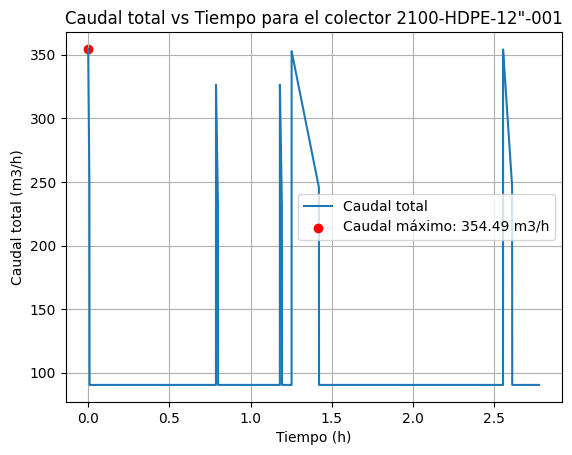

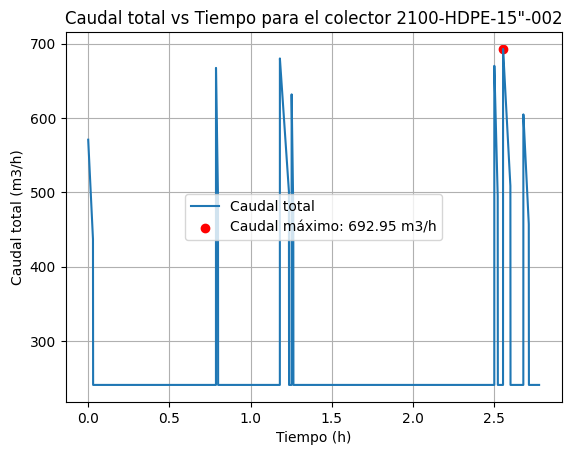

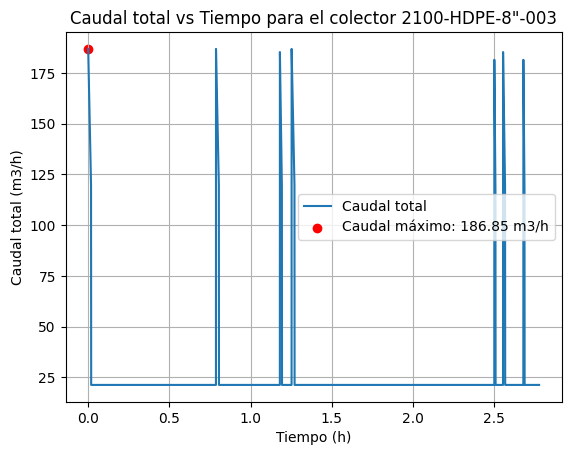

In [70]:
def graficar_caudales(colectores, caudales_totales, tiempo_total, paso_de_tiempo):
    tiempo = np.arange(0, tiempo_total, paso_de_tiempo) / 3600  # Convertir a horas

    for i, (colector, caudal_total) in enumerate(zip(colectores, caudales_totales)):
        plt.figure(i)
        plt.plot(tiempo[:10000], caudal_total[:10000] * 3600, label='Caudal total')  # Convertir a m3/h
        caudal_max = np.max(caudal_total) * 3600
        tiempo_max = tiempo[np.argmax(caudal_total)]
        plt.scatter(tiempo_max, caudal_max, color='red', label=f'Caudal máximo: {caudal_max:.2f} m3/h')
        plt.title(f'Caudal total vs Tiempo para el colector {colector}')
        plt.xlabel('Tiempo (h)')
        plt.ylabel('Caudal total (m3/h)')
        plt.legend()
        plt.grid()
        plt.show()


# Graficar caudales totales
graficar_caudales(colectores, caudales_totales, tiempo_total, paso_de_tiempo)